In [1]:
import os
os.chdir("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import folium
import shapely
from shapely.geometry import mapping, MultiPolygon, Point
import h3
import contextily as ctx

import warnings
warnings.filterwarnings("ignore")

In [2]:
dc = gpd.read_file(os.getcwd() + "/data/dc_2020.zip").to_crs("EPSG:4326")
dc.columns = [col.lower() for col in dc.columns]
dc.set_geometry("geometry")
dc.head(5)

,name,geoid,g20predbid,g20prertru,g20preljor,g20preghaw,g20preilar,g20preipie,g20preowri,g20deldnor,...,g20couowri,g20ussdstr,g20ussrwei,g20ussgory,g20ussowri,g20haldowo,g20halgrob,g20halisye,g20halowri,geometry
0,Precinct 111,11001111,1845,63,9,9,7,10,13,1736,...,18,1540,59,184,19,1486,192,81,15,"POLYGON ((-76.96352 38.87707, -76.96362 38.877..."
1,Precinct 106,11001106,2090,59,6,2,3,5,19,1916,...,22,1718,65,179,14,1681,190,78,11,"POLYGON ((-76.92916 38.88070, -76.92606 38.880..."
2,Precinct 131,11001131,4778,820,74,14,10,7,111,4016,...,56,3816,1135,364,77,3699,310,729,197,"POLYGON ((-77.00205 38.88049, -77.00194 38.880..."
3,Precinct 108,11001108,903,25,1,4,3,4,13,828,...,7,751,22,74,12,715,74,48,16,"POLYGON ((-76.96089 38.87785, -76.96082 38.877..."
4,Precinct 140,11001140,1263,46,5,7,8,2,11,1164,...,9,1053,57,121,7,1024,120,67,6,"POLYGON ((-76.97510 38.87425, -76.97516 38.874..."


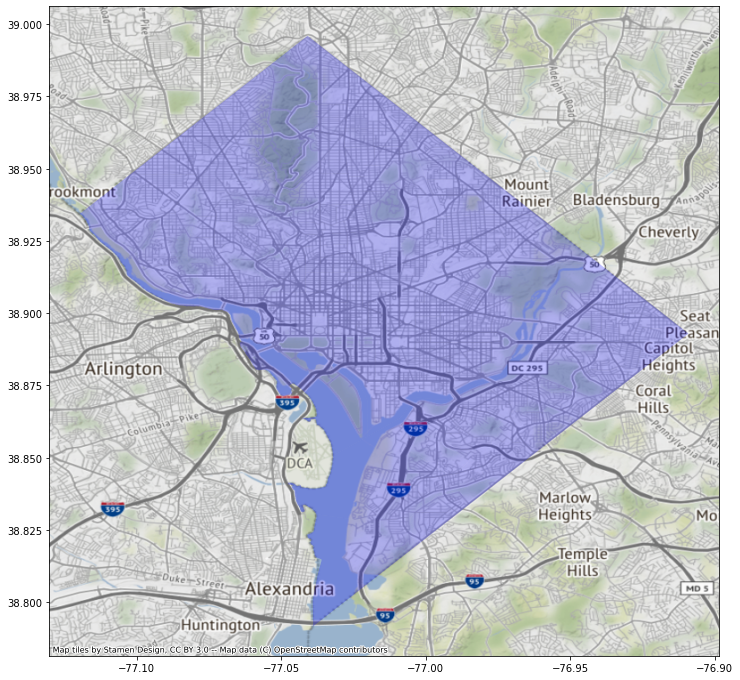

In [3]:
ax = dc.plot(alpha=0.25, color="blue", figsize=(12, 12))
ctx.add_basemap(ax, crs=dc.crs.to_string())

In [4]:
dc_polygons = shapely.geometry.MultiPolygon([geom for geom in dc.geometry])
hex_list = []
for geom in dc_polygons.geoms:
    temp = mapping(geom)
    temp['coordinates'] = [[[j[1], j[0]] for j in i]
                           for i in temp['coordinates']]
    hex_list.extend(h3.polyfill(temp, 8))

In [5]:
dch = pd.DataFrame(hex_list, columns=["hex8"])
print('number of duplicates:', len(hex_list) - len(dch.drop_duplicates()))

dch['lat'] = dch["hex8"].apply(lambda x: h3.h3_to_geo(x)[0])
dch['lng'] = dch["hex8"].apply(lambda x: h3.h3_to_geo(x)[1])
dch['geometry'] = dch.apply(lambda x: Point(x.lng, x.lat), 1)
dch = gpd.GeoDataFrame(dch).set_geometry("geometry")
dch.crs = "EPSG:4326"
dch.head(5)

number of duplicates: 0


,hex8,lat,lng,geometry
0,882aa844a7fffff,38.876557,-76.967828,POINT (-76.96783 38.87656)
1,882aa87a49fffff,38.868947,-76.964994,POINT (-76.96499 38.86895)
2,882aa84487fffff,38.878097,-76.939094,POINT (-76.93909 38.87810)
3,882aa844bdfffff,38.872510,-76.946785,POINT (-76.94678 38.87251)
4,882aa84597fffff,38.875011,-76.996561,POINT (-76.99656 38.87501)


In [6]:
dc_gh = dc.sjoin(dch, how="inner")
dc_gh.head(5)

,name,geoid,g20predbid,g20prertru,g20preljor,g20preghaw,g20preilar,g20preipie,g20preowri,g20deldnor,...,g20ussowri,g20haldowo,g20halgrob,g20halisye,g20halowri,geometry,index_right,hex8,lat,lng
0,Precinct 111,11001111,1845,63,9,9,7,10,13,1736,...,19,1486,192,81,15,"POLYGON ((-76.96352 38.87707, -76.96362 38.877...",1,882aa87a49fffff,38.868947,-76.964994
0,Precinct 111,11001111,1845,63,9,9,7,10,13,1736,...,19,1486,192,81,15,"POLYGON ((-76.96352 38.87707, -76.96362 38.877...",0,882aa844a7fffff,38.876557,-76.967828
1,Precinct 106,11001106,2090,59,6,2,3,5,19,1916,...,14,1681,190,78,11,"POLYGON ((-76.92916 38.88070, -76.92606 38.880...",3,882aa844bdfffff,38.872510,-76.946785
1,Precinct 106,11001106,2090,59,6,2,3,5,19,1916,...,14,1681,190,78,11,"POLYGON ((-76.92916 38.88070, -76.92606 38.880...",2,882aa84487fffff,38.878097,-76.939094
2,Precinct 131,11001131,4778,820,74,14,10,7,111,4016,...,77,3699,310,729,197,"POLYGON ((-77.00205 38.88049, -77.00194 38.880...",4,882aa84597fffff,38.875011,-76.996561


In [7]:
dc_gh["color"] = np.where(dc_gh.g20predbid > dc_gh.g20prertru, "blue", "red")

In [8]:
def hex_to_polylines(hexagons: list):
    polylines = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        polylines.append(polyline)
    return polylines

In [9]:
m = folium.Map(location=[38.897957, -77.036560],
               zoom_start=12,
               tiles='cartodbpositron')
polylines = hex_to_polylines(dc_gh["hex8"])

feature_h3 = folium.FeatureGroup(name="H3")
for polyline, color in zip(polylines, dc_gh["color"]):
    line = folium.PolyLine(locations=polyline, color=color, weight=4)
    line.add_to(feature_h3)
feature_h3.add_to(m)

feature_geometry = folium.FeatureGroup(name="Precinct")
for _, r in dc.iterrows():
    gj = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.0001).to_json()
    folium.GeoJson(data=gj,
                   popup=folium.Popup(r["name"], width=100),
                   style_function=lambda x: {
                       "color": "yellow",
                       "fillColor": "green",
                       "fillOpacity": 0.4
                   }).add_to(feature_geometry)
feature_geometry.add_to(m)
folium.LayerControl().add_to(m)
m

In [10]:
# Convert h3 hexagons to Polygon
h3_geoms = []
for hex in dch["hex8"]:
    geom = shapely.geometry.Polygon(h3.h3_to_geo_boundary(hex))
    h3_geoms.append(geom)

dc_h3_geoms = shapely.geometry.MultiPolygon([geom for geom in h3_geoms])

In [21]:
test = gpd.GeoDataFrame({"hex8": dch["hex8"], "geometry": h3_geoms}, crs='EPSG:4326')
test = test['geometry'].to_crs({'proj':'cea'}) 
test.area.sum() / 10**6

1.8383135207363075e-08